For this step we're going to use Keras. This will also start up your GPU if you're using one, which can take up to **10 seconds**.

In [12]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
print keras.__version__
print tf.__version__
from keras.optimizers import SGD

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2.2.4
1.15.0


Now let's load the data, and convert the labels to categories. So `0` becomes `[1, 0]` and `1` becomes `[0, 1]`. This makes it easy to add more classes later (like "angry", "sad", etc.) and interpret the predictions as probabilities. We do this after loading the file instead of before saving to avoid having a big labels file on disk.

Then we shuffle all the examples to make sure we don't hold out only one class for validation. And finally we count up how many instances there are of each class to make ensure that we put more emphasis on the rarer ones during training.

In [13]:
# load the data
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

# convert classes to vector
nb_classes = 2
y_train = np_utils.to_categorical(y_train, nb_classes).astype(np.float32)

# shuffle all the data
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y_train.sum(axis=0)
class_weight = class_totals.max() / class_totals

print x_train.dtype, x_train.min(), x_train.max(), x_train.shape
print y_train.dtype, y_train.min(), y_train.max(), y_train.shape

float32 0.0 1.0 (36348, 32, 32, 1)
float32 0.0 1.0 (36348, 2)


Now we set up our network. It is based on the Keras `mnist_cnn.py` example, following in the footsteps of VGG net by using small 3x3 convolutions with max pooling, and a final stage of multiple dense layers.

In [14]:
nb_filters = 16
nb_pool = 2
nb_conv = 5

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 16)        6416      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                25664     
__________

Now that our data and model is ready, we can train the model on the data for a few epochs, holding out 10% of the data for validating the accuracy. This should take about **30 seconds**.

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X, X_val, y, Y_val = train_test_split(x_train,y_train, test_size=0.08, shuffle=True, random_state=2019)

datagen = ImageDataGenerator(
            rotation_range=15, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.05)
datagen.fit(X)
    
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
# history = model.fit_generator(datagen.flow(X, y, batch_size=200), steps_per_epoch=len(X)/100, 
#                     epochs=100, validation_data=(X_val,Y_val),callbacks=[reduce_lr])

history = model.fit_generator(datagen.flow(X, y, batch_size=200), steps_per_epoch=len(X)/100, 
                     epochs=20, validation_data=(X_val,Y_val))

# validation_split = 0.10
# history = model.fit(x_train, y_train, batch_size=128, class_weight=class_weight, epochs=50, verbose=1, validation_split=validation_split)

Epoch 1/20
334/334 [==============================] - 30s 89ms/step - loss: 0.4122 - acc: 0.8229 - val_loss: 0.2908 - val_acc: 0.8779
Epoch 2/20
334/334 [==============================] - 28s 83ms/step - loss: 0.3195 - acc: 0.8668 - val_loss: 0.2585 - val_acc: 0.8920
Epoch 3/20
334/334 [==============================] - 32s 96ms/step - loss: 0.2826 - acc: 0.8835 - val_loss: 0.2197 - val_acc: 0.9188
Epoch 4/20
334/334 [==============================] - 29s 86ms/step - loss: 0.2608 - acc: 0.8947 - val_loss: 0.2030 - val_acc: 0.9199
Epoch 5/20
334/334 [==============================] - 28s 83ms/step - loss: 0.2457 - acc: 0.9004 - val_loss: 0.1963 - val_acc: 0.9216
Epoch 6/20
334/334 [==============================] - 26s 78ms/step - loss: 0.2346 - acc: 0.9040 - val_loss: 0.2043 - val_acc: 0.9157
Epoch 7/20
334/334 [==============================] - 29s 87ms/step - loss: 0.2284 - acc: 0.9077 - val_loss: 0.1869 - val_acc: 0.9240
Epoch 8/20
334/334 [==============================] - 31s 91ms

That got us to 90% validation accuracy, following the training accuracy pretty closely. To get it down more we might try tweaking the hyperparameters (number of filters, size of dense layers, etc.) or lowering the learning rate after a few epochs. But for now we will just save the model.

In [16]:
open('gender_model.json', 'w').write(model.to_json())
model.save_weights('gender_weights.h5')

To visually check the accuracy and loss, we can plot them to verify that there aren't any unexpected kinks or noise.

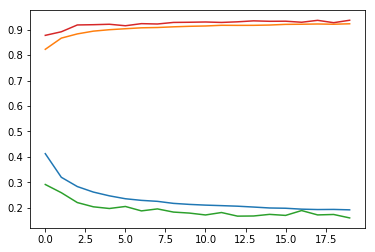

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])
plt.show()

In [18]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# convert classes to vector
nb_classes = 2
y_test = np_utils.to_categorical(y_test, nb_classes).astype(np.float32)

# shuffle all the data
indices = np.arange(len(x_test))
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

print x_test.dtype, x_test.min(), x_test.max(), x_test.shape
print y_test.dtype, y_test.min(), y_test.max(), y_test.shape

loss, accuracy = model.evaluate(x_test, y_test)
print("loss:",loss)
print("accuracy:",accuracy)

float32 0.0 1.0 (2000, 32, 32, 1)
float32 0.0 1.0 (2000, 2)
2000/2000 [==============================] - 0s 195us/step
('loss:', 0.23045323610305787)
('accuracy:', 0.916)


Bonus (optional): let's check the area under the receiver operating characteristic curve (ROC AUC) so we can compare to other work.

In [14]:
# from sklearn.metrics import roc_auc_score
# n_validation = int(len(X_test) * validation_split)
# y_predicted = model.predict(X[-n_validation:])
# print roc_auc_score(y[-n_validation:], y_predicted)

NameError: name 'X' is not defined

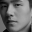

(900, 32, 32, 1)


In [19]:
from utils import show_array
import numpy as np

import keras
from keras.models import model_from_json
model1 = model_from_json(open('model.json').read())
model1.load_weights('weights.h5')

X = np.load('x_test.npy')
class_names = ['Neutral', 'Smiling']
img = X[-7]
show_array(255 * img)

print(X[100:1000].shape)

probabilities = model1.predict(X[100:1000])

0 : conv2d_9_input, <keras.engine.input_layer.InputLayer object at 0xb449fc8d0>
1 : conv2d_9, <keras.layers.convolutional.Conv2D object at 0xb449fc750>
2 : conv2d_9__activation__, <keras.layers.core.Activation object at 0x1a531dd0d0>
3 : max_pooling2d_9, <keras.layers.pooling.MaxPooling2D object at 0x1a526835d0>
4 : conv2d_10, <keras.layers.convolutional.Conv2D object at 0x1a52f11650>
5 : conv2d_10__activation__, <keras.layers.core.Activation object at 0x1a531ee6d0>
6 : max_pooling2d_10, <keras.layers.pooling.MaxPooling2D object at 0x1a52f19910>
7 : flatten_5, <keras.layers.core.Flatten object at 0x1a52f1fb90>
8 : dense_13, <keras.layers.core.Dense object at 0x1a52f3a4d0>
9 : dense_13__activation__, <keras.layers.core.Activation object at 0x1a531ee910>
10 : dense_14, <keras.layers.core.Dense object at 0x1a52f464d0>
11 : dense_14__activation__, <keras.layers.core.Activation object at 0x1a531ee990>


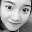

Female


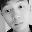

Male


In [20]:
#coreml模型
from utils import show_array
import numpy as np
import PIL.Image
import IPython.display

import keras
from keras.models import model_from_json
model = model_from_json(open('gender_model.json').read())
model.load_weights('gender_weights.h5')

from keras.models import load_model
import coremltools

import coremltools

coreml_model = coremltools.converters.keras.convert(model,input_names='data', image_input_names='data',output_names='outTensor')
coreml_model.save('gender.mlmodel')

# X = np.load('X.npy')
# Y = np.load('Y.npy')
class_names = ['Female', 'Male']
# img = X[-8]
# show_array(255 * img)

#check female
# raw_img = 255*img
# raw_img = np.squeeze(raw_img)
# raw_img = np.uint8(np.clip(raw_img, 0, 255))
# img = PIL.Image.fromarray(raw_img)
img = PIL.Image.open('../dataset/Gender/testdata/Female/b12_8.jpg')
newsize = (32, 32) 
img = img.resize(newsize) 
display(img)

mlmodel = coremltools.models.MLModel('gender.mlmodel')
out = mlmodel.predict({'data': img})
ret = out['outTensor']
print class_names[np.argmax(ret)]

#check male
img = PIL.Image.open('../dataset/Gender/testdata/Male/b12_170.jpg').convert('L')
newsize = (32, 32) 
img = img.resize(newsize)
display(img)

mlmodel = coremltools.models.MLModel('gender.mlmodel')
out = mlmodel.predict({'data': img})
ret = out['outTensor']
print class_names[np.argmax(ret)]